Rolling metrics snapshot (latest):
       metric    latest
    Vol (ann)  0.182215
       Sharpe  1.003998
      Sortino  1.427522
Beta vs Bench  1.385940
Corr vs Bench  0.827937
   Window MDD -0.040042
    VaR 1d 5% -0.016889
   CVaR 1d 5% -0.031587
       Calmar  4.568765

Saved rolling metrics time series to: C:\Users\adity\Downloads\Learn_DSA_Quant\Level-21\portfolio_rolling_metrics.csv


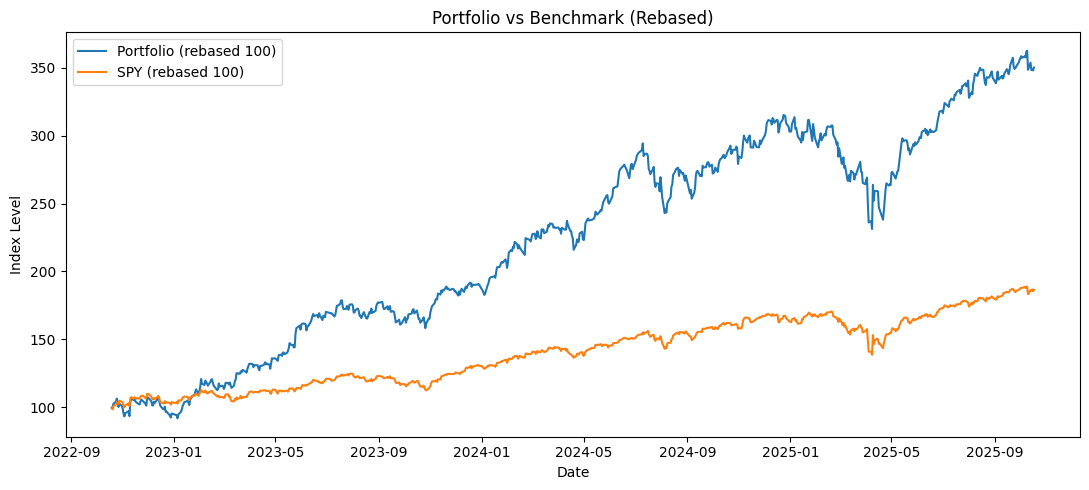

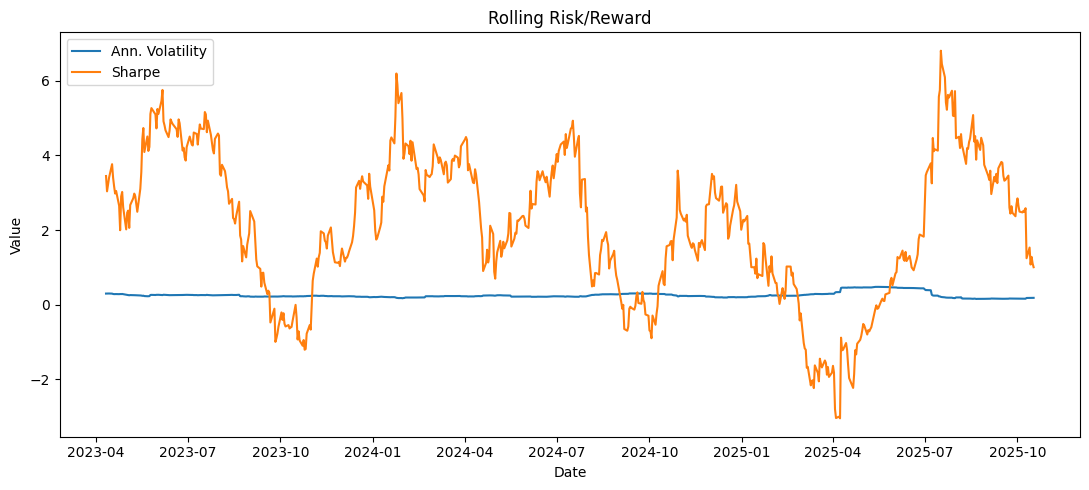

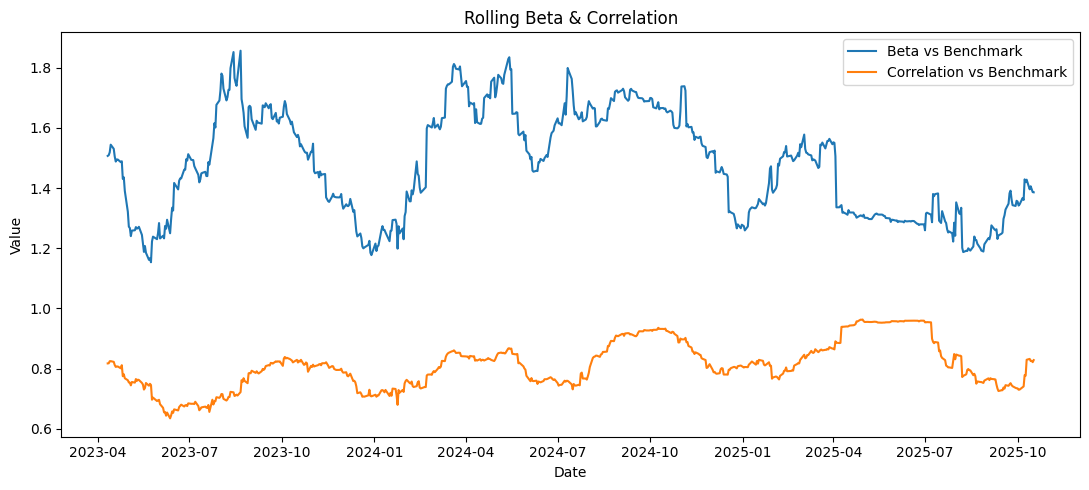

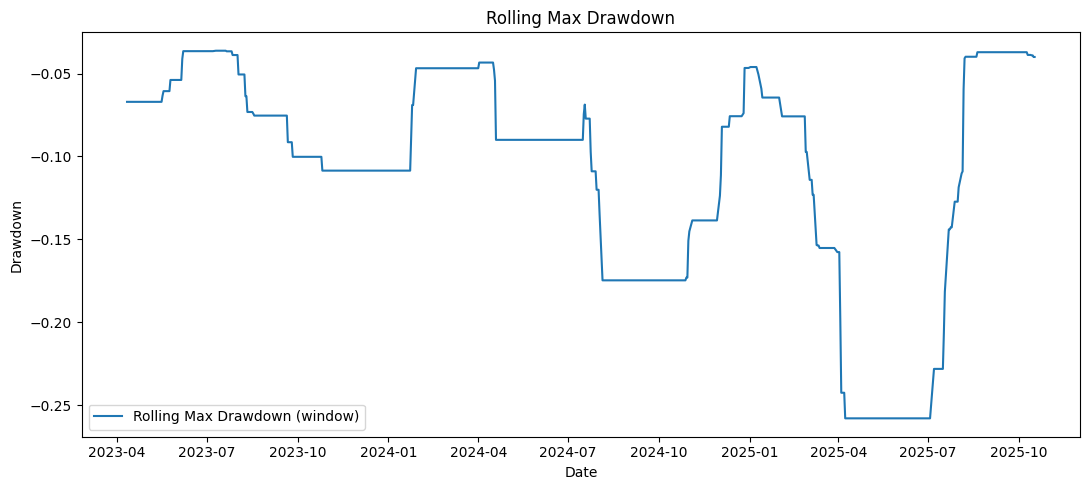

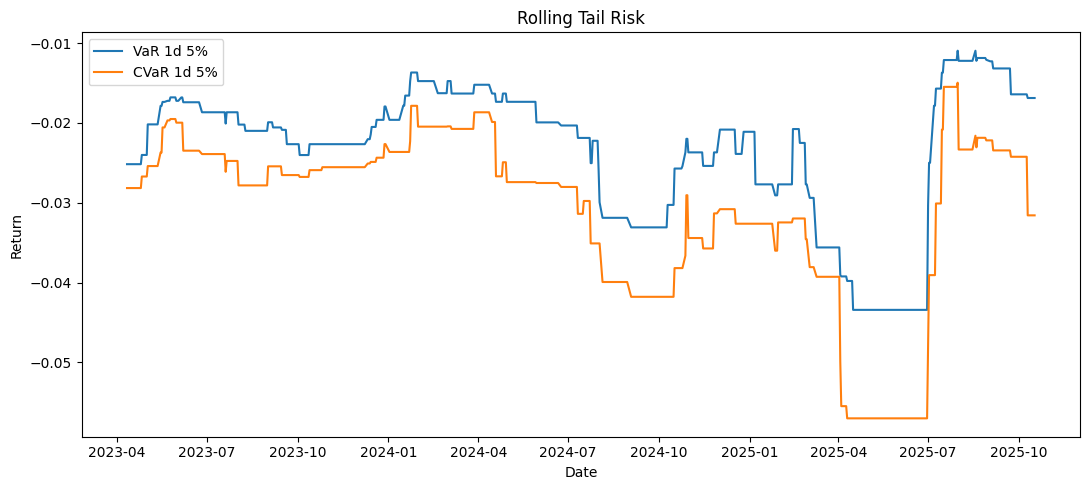

In [1]:
# Step 21 — Sliding Window + Portfolio Rolling Metrics (one cell, hardened)

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional

# ------------------------ User Params ------------------------
TICKERS: List[str] = ["AAPL", "MSFT", "NVDA", "AMZN"]  # portfolio tickers
WEIGHTS: Optional[Dict[str, float]] = None             # e.g., {"AAPL":0.3,"MSFT":0.3,"NVDA":0.2,"AMZN":0.2}
BENCH_TICKER: str = "SPY"                              # benchmark (beta/corr)
LOOKBACK_YEARS: int = 3                                # price history length
WINDOW: int = 60                                       # rolling window in trading days
ALPHA: float = 0.05                                    # VaR/CVaR tail probability
ANN_FACTOR: int = 252                                  # trading days per year
OUT_DIR = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-21")  # change if desired
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------ Helpers ------------------------
def to_1d(a) -> np.ndarray:
    return np.asarray(a, dtype=float).reshape(-1)

def last_scalar(a) -> float:
    arr = to_1d(a)
    return float(arr[-1]) if arr.size else float("nan")

def download_prices(tickers: List[str], years=3):
    period = f"{years}y"
    try:
        df = yf.download(" ".join(tickers), period=period, interval="1d", auto_adjust=True, progress=False)
        if isinstance(df.columns, pd.MultiIndex):
            # Use Close if present
            if ("Close" in df.columns.get_level_values(0)):
                px = df["Close"].copy()
            else:
                # fall back: take the last level if structure odd
                level0 = df.columns.get_level_values(0)
                first = level0.unique()[0]
                px = df[first].copy()
        else:
            # Single ticker case
            px = df[["Close"]].copy()
            px.columns = [tickers[0]]
        # Drop rows with all NaNs and forward-fill small gaps
        px = px.dropna(how="all").ffill().dropna(how="any")
        return px
    except Exception:
        return pd.DataFrame()

def make_synthetic(tickers: List[str], years=3, seed=7):
    np.random.seed(seed)
    n = years*ANN_FACTOR
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    data = {}
    for i, t in enumerate(tickers):
        mu = 0.12 + 0.02*np.random.randn()        # drift
        vol = 0.25 + 0.05*np.random.randn()       # annualized vol
        dt = 1/ANN_FACTOR
        ret = (mu - 0.5*vol**2)*dt + vol*np.sqrt(dt)*np.random.randn(n)
        price = 100*np.exp(np.cumsum(ret))
        data[t] = price
    return pd.DataFrame(data, index=dates)

def safe_weights(tickers: List[str], weights: Optional[Dict[str,float]]):
    if not weights:
        w = pd.Series(1.0/len(tickers), index=tickers)
    else:
        w = pd.Series({t: weights.get(t, 0.0) for t in tickers}, dtype=float)
        s = w.sum()
        if s == 0: w[:] = 1.0/len(tickers)
        else: w /= s
    return w

def returns_from_prices(px: pd.DataFrame, log=False):
    if log:
        r = np.log(px/px.shift(1))
    else:
        r = px.pct_change()
    return r.dropna(how="any")

def rolling_beta_alpha(y: pd.Series, x: pd.Series, window: int):
    """
    Rolling beta (slope) and alpha (intercept) of y on x via cov/var.
    """
    cov = y.rolling(window).cov(x)
    var = x.rolling(window).var()
    beta = cov / var
    # alpha = mean(y) - beta*mean(x), on window
    my = y.rolling(window).mean()
    mx = x.rolling(window).mean()
    alpha = my - beta*mx
    return beta, alpha

def rolling_sortino(r: pd.Series, window: int, ann=252):
    mean = r.rolling(window).mean()
    downside = r.copy()
    downside[downside > 0] = 0.0
    dstd = downside.rolling(window).std()
    return (mean / dstd) * np.sqrt(ann)

def rolling_drawdown(px: pd.Series, window: int):
    """
    Rolling max drawdown over a trailing window. Uses windowed peak-to-trough within each window.
    """
    # windowed rolling max of price
    roll_max = px.rolling(window).max()
    dd = px/roll_max - 1.0
    # For a true max drawdown within window, take rolling minimum of dd
    roll_mdd = dd.rolling(window).min()
    return roll_mdd

def rolling_var_cvar(r: pd.Series, window: int, alpha=0.05, scale=1.0):
    """
    Rolling one-period VaR/CVaR at alpha; scale allows annualization or other scaling.
    """
    # Rolling quantile for VaR (as a negative number for left tail)
    var = r.rolling(window).quantile(alpha) * scale
    # CVaR: average of returns <= VaR in each window. Approximate via rolling apply.
    def cvar_func(x):
        if len(x) == 0: return np.nan
        q = np.quantile(x, alpha)
        tail = x[x <= q]
        return tail.mean() if tail.size else q
    cvar = r.rolling(window).apply(cvar_func, raw=True) * scale
    return var, cvar

# ------------------------ Pipeline ------------------------
all_tickers = list(dict.fromkeys(TICKERS + [BENCH_TICKER]))
px = download_prices(all_tickers, years=LOOKBACK_YEARS)
if px.empty:
    px = make_synthetic(all_tickers, years=LOOKBACK_YEARS)

# Ensure we have all requested columns
missing = [t for t in all_tickers if t not in px.columns]
if missing:
    # Drop missing weights later; keep going with existing
    print(f"Warning: missing prices for {missing}. They will be excluded.")
    present = [t for t in TICKERS if t in px.columns]
    if not present:
        raise SystemExit("No portfolio tickers with data.")
    TICKERS = present
    # If benchmark missing, synthesize as equal-weight of remaining
    if BENCH_TICKER not in px.columns:
        px[BENCH_TICKER] = px[TICKERS].mean(axis=1)

px = px.sort_index().dropna(how="any")  # strict to align
w = safe_weights(TICKERS, WEIGHTS).loc[TICKERS]

r = returns_from_prices(px, log=False)
r_port = (r[TICKERS] @ w.values).rename("port")
r_bench = r[BENCH_TICKER].rename("bench")

# Align
df_ret = pd.concat([r_port, r_bench], axis=1).dropna()

# Portfolio price index (rebased to 100)
port_px = (1.0 + df_ret["port"]).cumprod() * 100.0
bench_px = (1.0 + df_ret["bench"]).cumprod() * 100.0

# ------------------------ Rolling Metrics ------------------------
roll_vol = df_ret["port"].rolling(WINDOW).std() * np.sqrt(ANN_FACTOR)
roll_sharpe = (df_ret["port"].rolling(WINDOW).mean() / df_ret["port"].rolling(WINDOW).std()) * np.sqrt(ANN_FACTOR)
roll_sortino = rolling_sortino(df_ret["port"], WINDOW, ann=ANN_FACTOR)

beta, alpha = rolling_beta_alpha(df_ret["port"], df_ret["bench"], WINDOW)
roll_corr = df_ret["port"].rolling(WINDOW).corr(df_ret["bench"])

roll_mdd = rolling_drawdown(port_px, WINDOW)  # (negative)
roll_var, roll_cvar = rolling_var_cvar(df_ret["port"], WINDOW, alpha=ALPHA, scale=1.0)

# Calmar: annualized return / |MDD|. Compute trailing annualized return on window.
win_mean = df_ret["port"].rolling(WINDOW).mean()
roll_ann_ret = win_mean * ANN_FACTOR
roll_calmar = roll_ann_ret / np.abs(roll_mdd)

# ------------------------ Assemble Output Table ------------------------
metrics = pd.DataFrame({
    "port_vol_ann": roll_vol,
    "port_sharpe": roll_sharpe,
    "port_sortino": roll_sortino,
    "port_beta": beta,
    "port_alpha": alpha,
    "port_corr_bench": roll_corr,
    "port_mdd_window": roll_mdd,     # negative values
    "port_var_1d_5%": roll_var,      # one-day VaR at 5%
    "port_cvar_1d_5%": roll_cvar,    # one-day CVaR at 5%
    "port_ann_ret_window": roll_ann_ret,
    "port_calmar": roll_calmar
}).dropna()

# ------------------------ Summary Snapshot ------------------------
def latest_safe(s: pd.Series, name: str):
    try:
        v = last_scalar(s.dropna())
        return (name, v if np.isfinite(v) else np.nan)
    except Exception:
        return (name, np.nan)

summary_pairs = [
    latest_safe(metrics["port_vol_ann"], "Vol (ann)"),
    latest_safe(metrics["port_sharpe"], "Sharpe"),
    latest_safe(metrics["port_sortino"], "Sortino"),
    latest_safe(metrics["port_beta"], "Beta vs Bench"),
    latest_safe(metrics["port_corr_bench"], "Corr vs Bench"),
    latest_safe(metrics["port_mdd_window"], "Window MDD"),
    latest_safe(metrics["port_var_1d_5%"], "VaR 1d 5%"),
    latest_safe(metrics["port_cvar_1d_5%"], "CVaR 1d 5%"),
    latest_safe(metrics["port_calmar"], "Calmar"),
]
summary = pd.DataFrame(summary_pairs, columns=["metric","latest"])

print("Rolling metrics snapshot (latest):")
print(summary.to_string(index=False))

# ------------------------ Exports ------------------------
px_out = pd.concat([port_px.rename("port_index"), bench_px.rename("bench_index")], axis=1)
full_out = pd.concat([px_out, metrics], axis=1).dropna(how="any")
out_csv = OUT_DIR / "portfolio_rolling_metrics.csv"
full_out.to_csv(out_csv)
print(f"\nSaved rolling metrics time series to: {out_csv}")

# ------------------------ Plots ------------------------
plt.figure(figsize=(11,5))
plt.plot(px_out.index, px_out["port_index"], label="Portfolio (rebased 100)")
plt.plot(px_out.index, px_out["bench_index"], label=f"{BENCH_TICKER} (rebased 100)")
plt.title("Portfolio vs Benchmark (Rebased)")
plt.xlabel("Date"); plt.ylabel("Index Level")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,5))
plt.plot(metrics.index, metrics["port_vol_ann"], label="Ann. Volatility")
plt.plot(metrics.index, metrics["port_sharpe"], label="Sharpe")
plt.title("Rolling Risk/Reward")
plt.xlabel("Date"); plt.ylabel("Value")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,5))
plt.plot(metrics.index, metrics["port_beta"], label="Beta vs Benchmark")
plt.plot(metrics.index, metrics["port_corr_bench"], label="Correlation vs Benchmark")
plt.title("Rolling Beta & Correlation")
plt.xlabel("Date"); plt.ylabel("Value")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,5))
plt.plot(metrics.index, metrics["port_mdd_window"], label="Rolling Max Drawdown (window)")
plt.title("Rolling Max Drawdown")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,5))
plt.plot(metrics.index, metrics["port_var_1d_5%"], label="VaR 1d 5%")
plt.plot(metrics.index, metrics["port_cvar_1d_5%"], label="CVaR 1d 5%")
plt.title("Rolling Tail Risk")
plt.xlabel("Date"); plt.ylabel("Return")
plt.legend(); plt.tight_layout(); plt.show()
